### 0. Clone for data extraction

In [1]:
!git clone https://github.com/Daremitsu1/Identifying-Incomplete-House-Addresses.git

Cloning into 'Identifying-Incomplete-House-Addresses'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 21 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), 1.86 MiB | 6.23 MiB/s, done.


### 1. Install Dependencies

In [2]:
!sudo apt-get install libkrb5-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libkrb5-dev is already the newest version (1.17-6ubuntu4.2).
libkrb5-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [ ]:
!pip install arcgis==1.8.4  torch==1.4.0  fastai==1.0.60 torchvision==0.5.0 fastprogress pandas 

In [ ]:
!pip install transformers==3.3.0

In [ ]:
!pip list

### 2. Necessary Imports

In [5]:
import os, zipfile, pandas as pd
from pathlib import Path 
from arcgis.learn import prepare_textdata 
from arcgis.learn.text import TextClassifier

### 3. Data Preparation

In [6]:
filepath = 'country_classifier.zip'

In [7]:
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [8]:
DATA_ROOT = Path(os.path.join(os.path.splitext(filepath)[0]))

In [10]:
data = prepare_textdata(DATA_ROOT, "classification", train_file="country_addresses.csv", 
                        text_columns="Address", label_columns="Country", batch_size=64)

In [11]:
print(data.classes)

['BE', 'AU', 'ES', 'CA']


In [12]:
data.show_batch(10)

Address,Country
"303, UPPER PENNEYS HILL ROAD, ONKAPARINGA HILLS, SA, 5163",AU
"257, Brusselsesteenweg, 1730",BE
"28, Avenue d'Itterbeek, 1eET, 1070",BE
"70, Merksemsebaan, Wijnegem, 2110",BE
"20, CL JUAN MAMBRILLA, 47003",ES
"968, Ritchie Dr, Halifax, Halifax County",CA
"31, Schapenstraat, 3080",BE
"3D, Avenue de l'Hôpital, 5-2, 7000",BE
"476, ST ANDREWS POINT RD, LOWER MONTAGUE, KNS",CA
"18, HULL STREET, UNIT 5, GLENORCHY, TAS, 7010",AU


### 4. TextClassifier Model

In [13]:
print(TextClassifier.supported_backbones)

['BERT', 'RoBERTa', 'DistilBERT', 'ALBERT', 'FlauBERT', 'CamemBERT', 'XLNet', 'XLM', 'XLM-RoBERTa', 'Bart', 'ELECTRA', 'Longformer', 'MobileBERT']


In [14]:
print(TextClassifier.available_backbone_models("xlm-roberta"))

('xlm-roberta-base', 'xlm-roberta-large')


### 5. Load Model Architecture

In [15]:
model = TextClassifier(data, backbone="xlm-roberta-base")

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

### 6. Model Training

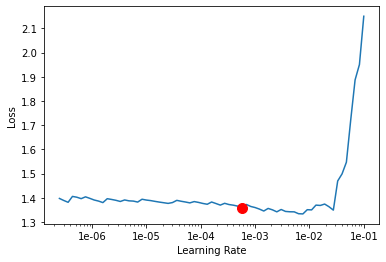

0.0005754399373371565

In [16]:
model.lr_find()

In [17]:
model.fit(epochs=4, lr=0.001)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.389619,1.370961,0.409836,0.590164,00:02
1,1.434942,1.274257,0.409836,0.590164,00:01
2,1.363781,1.316854,0.409836,0.590164,00:01
3,1.339480,1.317004,0.409836,0.590164,00:01


In [25]:
# Unfreeze earlier layers to further fine-tune the model
model.unfreeze()

model.fit(epochs=20)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.857449,0.963201,0.590164,0.409836,00:03
1,0.838847,0.923048,0.590164,0.409836,00:03
2,0.812575,0.801188,0.655738,0.344262,00:03
3,0.783079,0.689692,0.803279,0.196721,00:03
4,0.747281,0.533852,0.852459,0.147541,00:03
5,0.699880,0.441889,0.868852,0.131148,00:03
6,0.658984,0.440154,0.836066,0.163934,00:03
7,0.603308,0.243936,0.885246,0.114754,00:03
8,0.550244,0.345046,0.885246,0.114754,00:03
9,0.499957,0.272751,0.885246,0.114754,00:03


### 7. Validate the results

In [26]:
# After training, checking the results to see how it performs
model.show_results(15)

text,target,prediction
"2, CURRIE CRESCENT, UNIT 2D, GRIFFITH, ACT, 2603",AU,AU
"227, TOORAK ROAD, UNIT 103, SOUTH YARRA, VIC, 3141",AU,AU
"7, LEICHHARDT STREET, UNIT 34, WAVERLEY, NSW, 2024",AU,AU
"35, ANGELO STREET, UNIT 14, SOUTH PERTH, WA, 6151",AU,AU
"7-11, HAPPY VALLEY ROAD, PORT LINCOLN, SA, 5606",AU,AU
"11, DENHAM AVENUE, DENHAMS BEACH, NSW, 2536",AU,AU
"44, JONES STREET, MOOLOOLAH VALLEY, QLD, 4553",AU,AU
"36, GREYSTANES ROAD, GREYSTANES, NSW, 2145",AU,AU
"12, ARDEN AVENUE, DEVONPORT, TAS, 7310",AU,AU
"3280, OLIVIER-BEAULIEU, J4N0G8",CA,CA


### 8. Test the model prediction on an input text

In [27]:
text = """1016, 8A, CL RICARDO LEON - SANTA ANA (CARTAGENA), 30319"""
print(model.predict(text))

('1016, 8A, CL RICARDO LEON - SANTA ANA (CARTAGENA), 30319', 'ES', 0.9965837001800537)


### 9. Model metrics

In [28]:
# Check to see how accurate the model is in correctly predicting the classes in the dataset
model.accuracy()

1.0

In [29]:
# Also check precision, recall & f1 scores per label/class
model.metrics_per_label()

,Precision_score,Recall_score,F1_score,Support
AU,0.9286,1.0000,0.9630,13.0
BE,1.0000,1.0000,1.0000,25.0
CA,1.0000,0.9167,0.9565,12.0
ES,1.0000,1.0000,1.0000,11.0


### 10. Get misclassified records

In [30]:
# To get the misclassified records we will call the model's get_misclassified_records method
misclassified_records = model.get_misclassified_records()

In [31]:
misclassified_records.style.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])\
        .set_properties(**{'text-align': "left"}).hide_index()

Address,Target,Prediction
"3280, OLIVIER-BEAULIEU, J4N0G8",CA,AU


### 11. Save the model

In [32]:
model.save('text-classifier')

Computing model metrics...


PosixPath('models/text-classifier')